# BA plots

In [235]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from rdmulti import rdmc, rdms, rdmcplot
import statsmodels.api as sm
import math

def round_up_to(x, base=5):
    return int(math.ceil(x / float(base)) * base)

# plotting
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({'axes.grid':True,'grid.color':'black','grid.alpha':'0.25','grid.linestyle':'--'})
plt.rcParams.update({'font.size': 14})

# Set color cycle
cmap = plt.colormaps['Set3']
colors = cmap(np.linspace(0, 1, 5))   # 5 distinct colors
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [236]:
# import exceldata
df = pd.read_excel("Hjemsendelse 22-10-2025.xlsx", sheet_name="kvm_data")

#gen bs/sqm variable
df['bs_per_sqm'] = df['bs'] / df['sqm']

df.head(20)

,sqm,N,alder,ind,bs,leje,bs_per_sqm
0,41,14948,27.586098,138862.067335,488.080627,36429.203125,11.904406
1,42,18101,28.236064,140949.084549,503.692444,38265.359375,11.992677
2,43,16705,28.400539,141539.168001,509.922760,38417.808594,11.858669
3,44,17706,28.266915,146337.147782,512.827332,38426.824219,11.655167
4,45,18682,29.269778,149406.023504,517.209412,38610.585938,11.493542
5,46,18315,28.788152,150127.291816,539.462891,40156.433594,11.727454
6,47,18657,29.713244,152334.205833,534.371033,39777.941406,11.369596
7,48,21064,29.491645,154641.455334,544.067688,40496.398438,11.334743
8,49,23840,29.803104,154126.144334,550.972778,40845.015625,11.244342
9,50,40308,28.490449,148981.585614,554.658813,40987.175781,11.093176


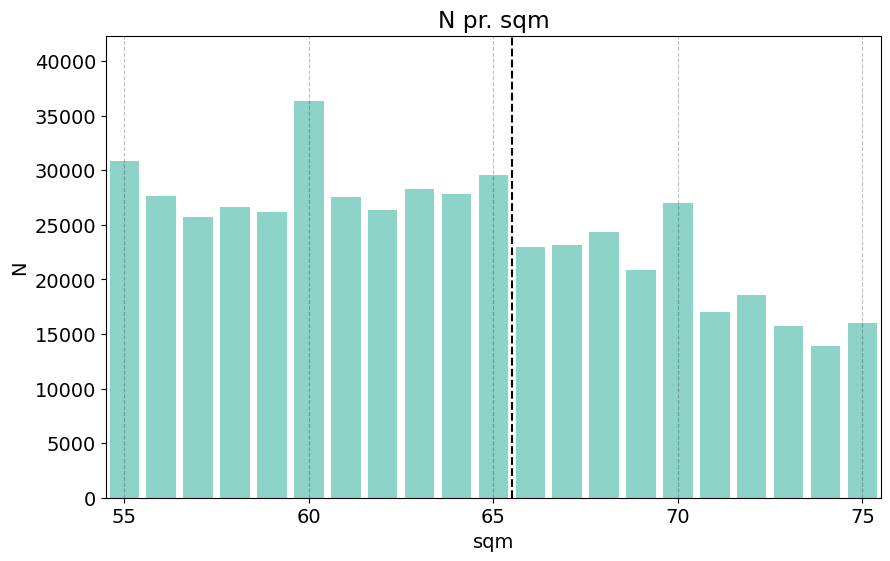

In [237]:
#Plot N on sqm
df = df.sort_values(by="sqm")

#make dotted line between bars 65 sqm and 66 sqm

plt.figure(figsize=(10,6))
plt.xlim(54.5, 75.5) # limit x-axis to 55-75 sqm
plt.xticks(np.arange(55, 76, 5))  # limit x-axis to 55-75 sqm
plt.bar(df['sqm'], df['N'])
plt.title('N pr. sqm')
plt.xlabel('sqm')
plt.ylabel('N')
plt.grid(axis='y')
x1 = 65
x2 = 66
midpoint = (x1 + x2) / 2
plt.axvline(x=midpoint, color='black', linestyle='--')
plt.show()

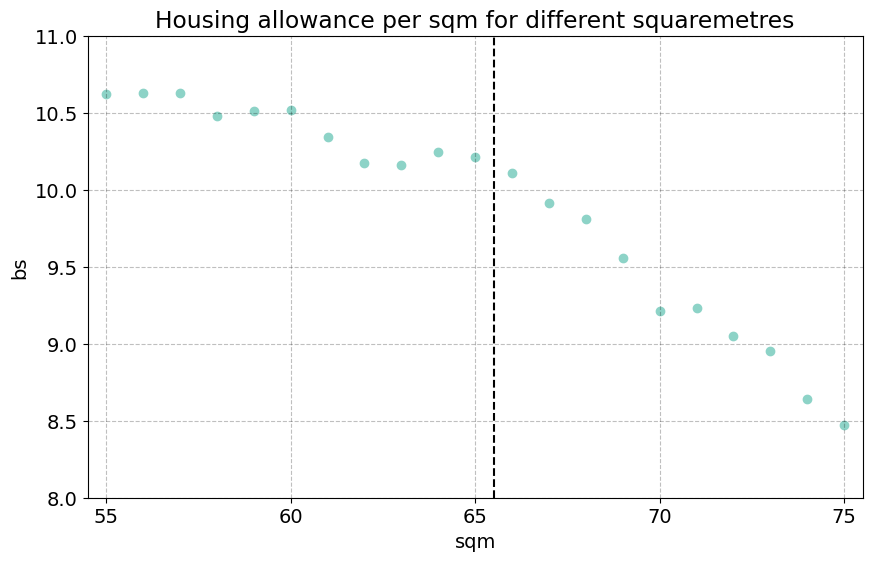

In [238]:
plt.figure(figsize=(10,6))

# scatter (dots) instead of bars
plt.scatter(df['sqm'], df['bs_per_sqm'])

plt.title('Housing allowance per sqm for different squaremetres')
plt.xlabel('sqm')
plt.ylabel('bs')
plt.grid(True)

# dotted separator between 65 and 66 sqm
x1 = 65
x2 = 66
midpoint = (x1 + x2) / 2
plt.axvline(x=midpoint, color='black', linestyle='--') # vertical dotted line

plt.ylim(8, 11) # limit y-axis
plt.xlim(54.5, 75.5) # limit x-axis
plt.xticks(np.arange(55, 76, 5))

plt.show()

/var/folders/fl/qg5hrzdx3ls1rmd_4w6mlrcw0000gn/T/ipykernel_70990/415298725.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/fl/qg5hrzdx3ls1rmd_4w6mlrcw0000gn/T/ipykernel_70990/415298725.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


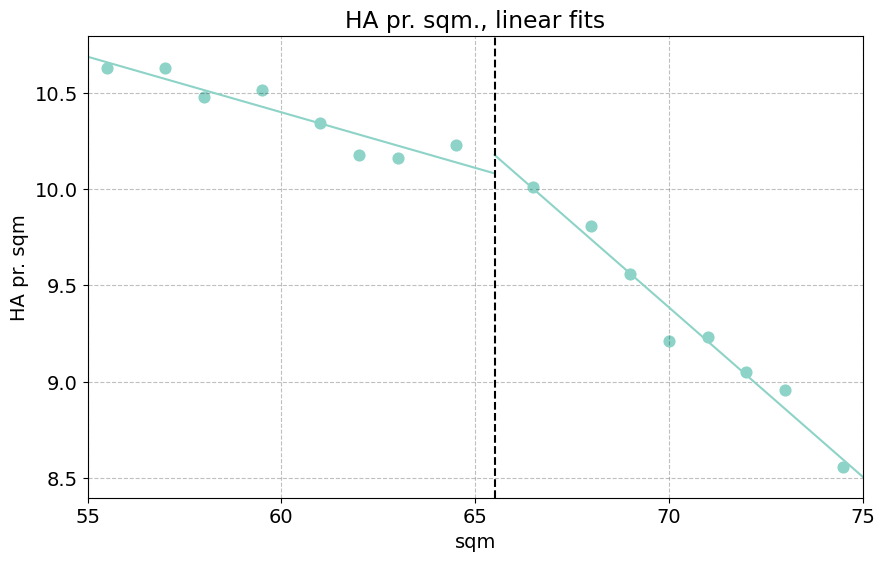

In [239]:
# First stage plot with polynomial (p=2) fits

# --- 1. Subset for RD window ---
df_left = df[(df['sqm'] >= 55) & (df['sqm'] <= 65)].copy()
df_right = df[(df['sqm'] >= 66) & (df['sqm'] <= 75)].copy()

# --- 2. Binscatter means ---
def binscatter(data, x, y, bins=8):
    data = data.copy()
    data['bin'] = pd.cut(data[x], bins=bins)
    out = data.groupby('bin').agg(mean_x=(x, 'mean'), mean_y=(y, 'mean')).dropna()
    return out

bin_left = binscatter(df_left, 'sqm', 'bs_per_sqm', bins=8)
bin_right = binscatter(df_right, 'sqm', 'bs_per_sqm', bins=8)

# --- 3. Two separate regressions ---
def linreg(df_bin):
    X = sm.add_constant(df_bin['mean_x'])
    y = df_bin['mean_y']
    model = sm.OLS(y, X).fit()
    return model.params['const'], model.params['mean_x']

a_L, b_L = linreg(bin_left)
a_R, b_R = linreg(bin_right)

# --- 4. Plot ---
plt.figure(figsize=(10,6))

# binscatter points
plt.scatter(bin_left['mean_x'], bin_left['mean_y'], s=60, color = colors[0])
plt.scatter(bin_right['mean_x'], bin_right['mean_y'], s=60, color = colors[0])

# left regression line
xL = np.linspace(df_left['sqm'].min(), df_left['sqm'].max()+0.5, 100)
yL = a_L + b_L * xL
plt.plot(xL, yL, color = colors[0])

# right regression line
xR = np.linspace(df_right['sqm'].min()-0.5, df_right['sqm'].max(), 100)
yR = a_R + b_R * xR
plt.plot(xR, yR, color = colors[0])

# --- 5. Cutoff line ---
cut = (65 + 66) / 2
plt.axvline(x=cut, linestyle='--', color='black')

# Aesthetics
plt.xlabel('sqm')
plt.ylabel('HA pr. sqm')
plt.title('HA pr. sqm., linear fits')
plt.grid(True)
plt.xticks(np.arange(55, 76, 5))
plt.xlim(55, 75)

plt.show()

/var/folders/fl/qg5hrzdx3ls1rmd_4w6mlrcw0000gn/T/ipykernel_70990/3486709309.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/fl/qg5hrzdx3ls1rmd_4w6mlrcw0000gn/T/ipykernel_70990/3486709309.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


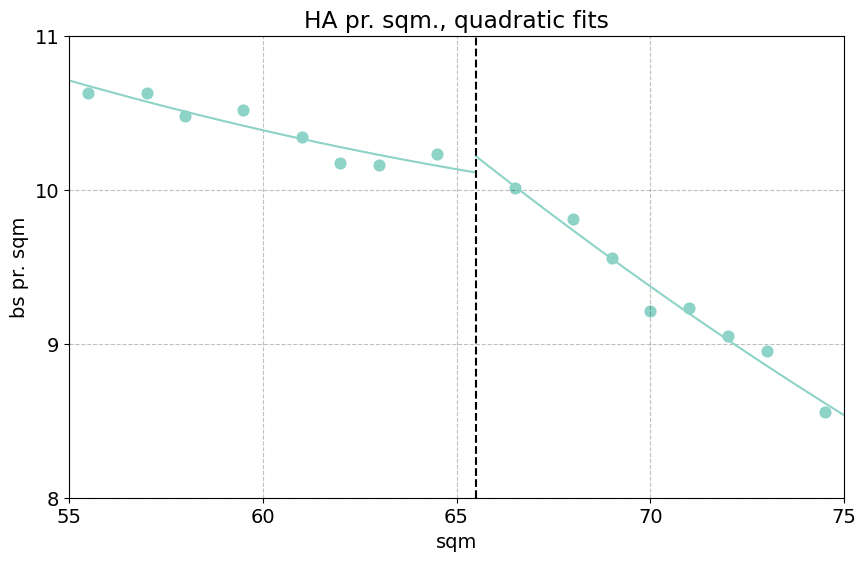

In [240]:
# First stage plot with polynomial (p=2) fits

# --- 1. Subset for RD window (55–75 sqm, change if needed) ---
df_left = df[(df['sqm'] >= 55) & (df['sqm'] <= 65)].copy()
df_right = df[(df['sqm'] >= 66) & (df['sqm'] <= 75)].copy()

# --- 2. Binscatter helper ---
def binscatter(data, x, y, bins=8):
    data = data.copy()
    data['bin'] = pd.cut(data[x], bins=bins)
    return data.groupby('bin').agg(mean_x=(x, 'mean'),
                                   mean_y=(y, 'mean')).dropna()

bin_left = binscatter(df_left, 'sqm', 'bs_per_sqm', bins=8)
bin_right = binscatter(df_right, 'sqm', 'bs_per_sqm', bins=8)

# --- 3. Polynomial regression (p = 2) on each side ---
def poly_reg(df_bin):
    df_bin = df_bin.copy()
    df_bin['x2'] = df_bin['mean_x']**2               # quadratic term
    X = sm.add_constant(df_bin[['mean_x', 'x2']])    # const + x + x^2
    y = df_bin['mean_y']
    model = sm.OLS(y, X).fit()
    return model

model_L = poly_reg(bin_left)
model_R = poly_reg(bin_right)

# Extract coefficients
a_L = model_L.params['const']
b_L1 = model_L.params['mean_x']
b_L2 = model_L.params['x2']

a_R = model_R.params['const']
b_R1 = model_R.params['mean_x']
b_R2 = model_R.params['x2']

# --- 4. Plot binscatter + polynomial fit ---
plt.figure(figsize=(10,6))

# Scatter points (binned means)
plt.scatter(bin_left['mean_x'], bin_left['mean_y'], s=60, color = colors[0])
plt.scatter(bin_right['mean_x'], bin_right['mean_y'], s=60, color = colors[0])

# Left polynomial line
xL = np.linspace(df_left['sqm'].min(), df_left['sqm'].max()+0.5, 100)
yL = a_L + b_L1*xL + b_L2*xL**2
plt.plot(xL, yL, color = colors[0])

# Right polynomial line
xR = np.linspace(df_right['sqm'].min()-0.5, df_right['sqm'].max(), 100)
yR = a_R + b_R1*xR + b_R2*xR**2
plt.plot(xR, yR, color = colors[0])

# --- Cutoff line ---
cut = (65 + 66) / 2  # halfway between bins
plt.axvline(x=cut, linestyle='--', color='black')

# Formatting
plt.xlabel('sqm')
plt.ylabel('bs pr. sqm')
plt.title('HA pr. sqm., quadratic fits')
plt.xticks(np.arange(55, 76, 5))
plt.xlim(55, 75)
plt.ylim(8, 11)
plt.yticks(np.arange(8, 11.0001, 1))

plt.show()

In [ ]:
#Defining function to load data and set index
def load_bw_data(sheet, sheet_name):
    df = pd.read_excel(sheet, sheet_name)
    df.set_index('bdwidth', inplace=True)
    return df

#Defining function to plot estimates with 95% CI
def plot_bw(df, title="Estimates with 95% CI", clr=colors[0]):
    #gen bs/sqm variable
    df['upper'] = df['estimate'] + df['stderr']*1.96
    df['lower'] = df['estimate'] - df['stderr']*1.96

    #Plot estimate, upper and lower for each bw. The errorbars are dotted lines of the same maint color as the points.
    plt.figure(figsize=(10,6))
    plt.plot(df['estimate'])
    plt.plot(df['upper'], linestyle='--', color=clr)
    plt.plot(df['lower'], linestyle='--', color=clr)
    plt.axhline(y=0, color='black', linewidth=1) #Plot a fat black horizontal line at y=0

    # Formatting
    plt.title(title)
    plt.xlabel('Bandwidth')
    plt.ylabel('Estimate')
    plt.xticks(np.arange(5, df.index[-1]+0.1, 5))
    plt.xlim(df.index[0], df.index[-1])
    plt.ylim(round_up_to(df.loc[5:,'lower'].min()-5,5), round_up_to(df.loc[5:,'upper'].max()+5,5))
    #set the ticks to be from -25 to 5 with steps of 5
    # Compute clean y-axis bounds
    y_min = round_up_to(df.loc[5:, 'lower'].min() - 5, 5)
    y_max = round_up_to(max(df.loc[5:, 'upper'].max() + 5, 5),5)

    # Apply ticks every 5, unless the range is bigger than 40
    plt.yticks(np.arange(y_min, y_max + 1, 5))


    plt.grid(True)
    plt.show()


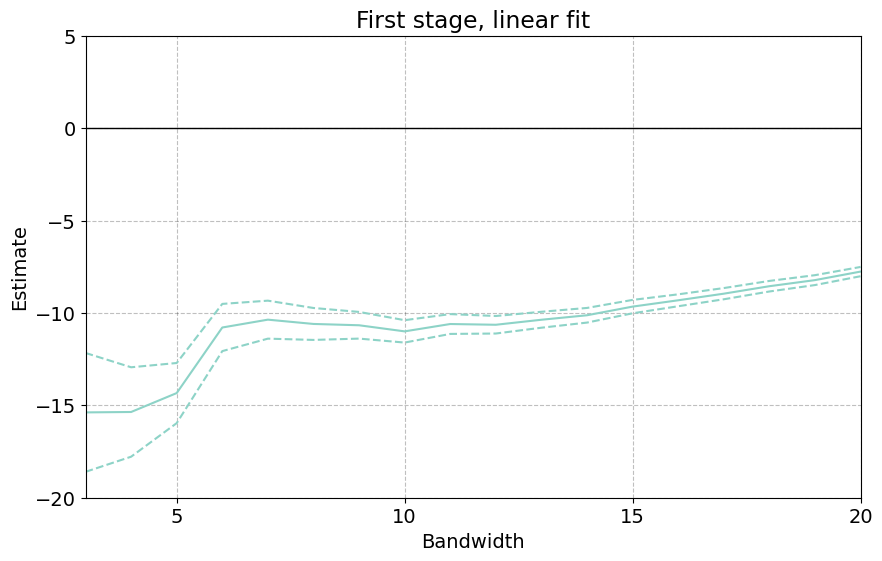

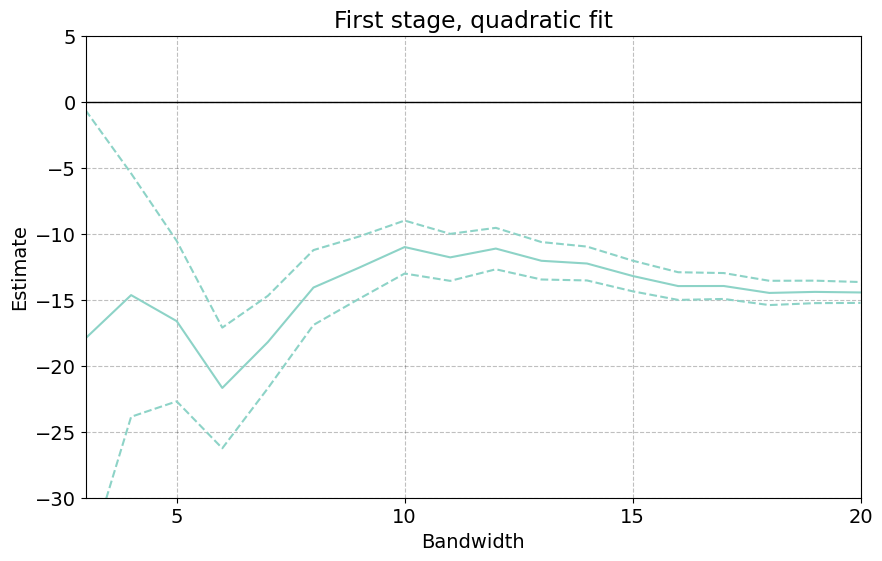

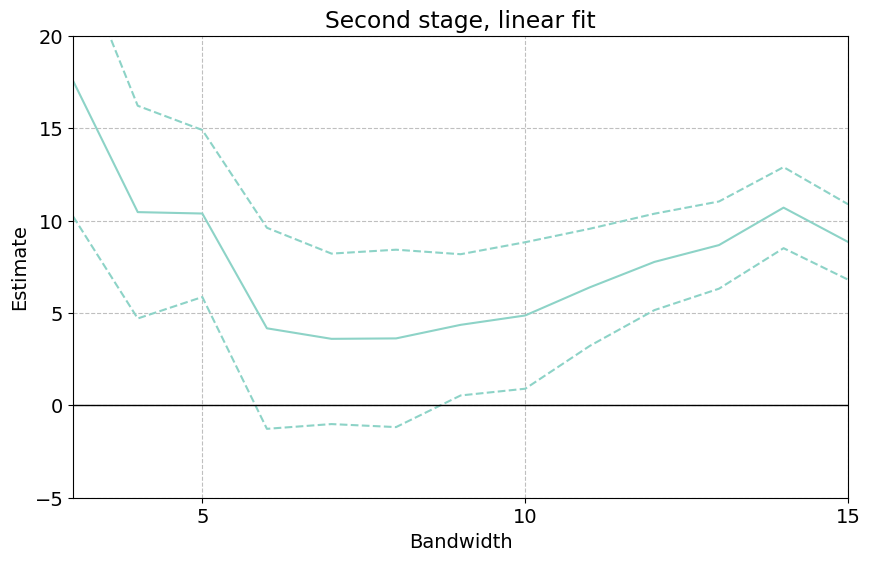

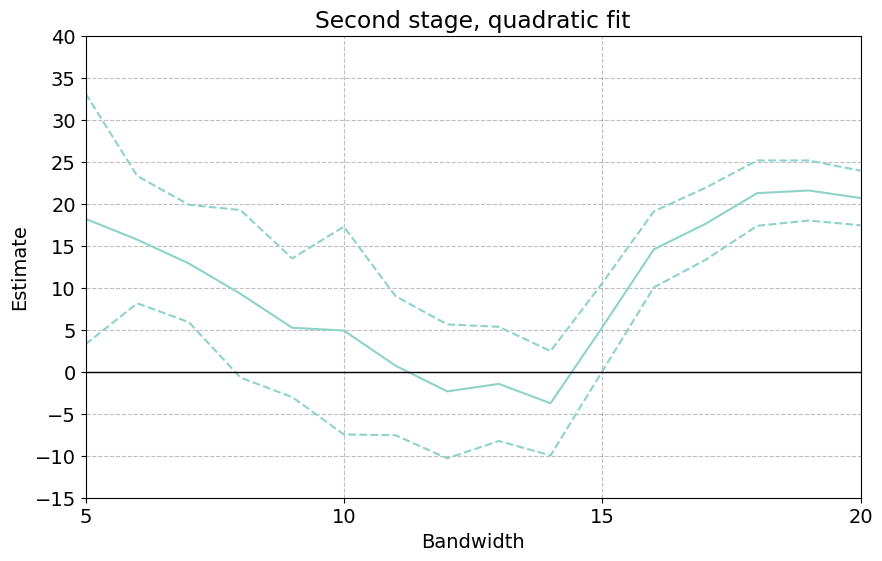

In [285]:
#Linear first stage
# import exceldata

first_lin= load_bw_data("Hjemsendelse 22-10-2025.xlsx", "first_ll.dta")
first_quad= load_bw_data("Hjemsendelse 22-10-2025.xlsx", "first_lq.dta")
second_lin= load_bw_data("Hjemsendelse 22-10-2025.xlsx", "Linear")
second_quad= load_bw_data("Hjemsendelse 22-10-2025.xlsx", "Quadratic")

#Definiting panels with titles
panels = {
    "First stage, linear fit": first_lin,
    "First stage, quadratic fit": first_quad,
    "Second stage, linear fit": second_lin,
    "Second stage, quadratic fit": second_quad
}

for name, d in panels.items():
    plot_bw(d, title=name, clr=colors[0])

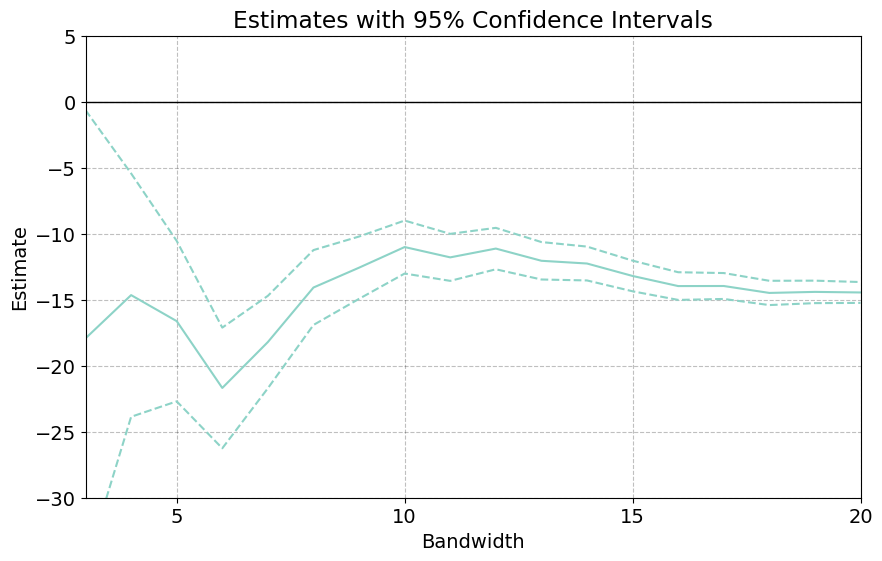

In [ ]:
#Plot estimate, upper and lower for each bw. The errorbars are dotted lines of the same maint color as the points.
plt.figure(figsize=(10,6))
plt.plot(df['estimate'])
plt.plot(df['upper'], linestyle='--', color=colors[0])
plt.plot(df['lower'], linestyle='--', color=colors[0])
plt.axhline(y=0, color='black', linewidth=1) #Plot a fat black horizontal line at y=0

# Formatting
plt.title('Estimates with 95% Confidence Intervals')
plt.xlabel('Bandwidth')
plt.ylabel('Estimate')
plt.xticks(np.arange(5, 20.001, 5))
plt.xlim(3, 20)
plt.ylim(round_up_to(df.loc[5:,'lower'].min()-5,5), max(df['upper'].max(),5))
#set the ticks to be from -25 to 5 with steps of 5
plt.yticks(np.arange(round_up_to(df.loc[5:,'lower'].min()-5,5), 5.001, 5))
plt.grid(True)  